# BootStrapping Workbook
--- Nov-18-2019, Alan, Shaolun.du@gmail.com

This is a detailed documentation on Yield Curve Bootstrapping. In the following, I will go over two different approaches on curve bootstrapping also includes topic on how to construct different types of curves: 

- Boostrapping by QuantLib (Full implementation for pricing)
- FX curve, OIS curve and SOFR curve (Maybe)
- Structure for wrapping curves for difference currencies

*** NOTE: I will use USD curve as an example going forward, and I will talk about how to get other major currency curves as variantion to USD curves in the end.


## 1 - QuantLib for curve building

To start, please import the library:

In [3]:
import math
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
def plot_helper( sDate,
                 yts,
                 N_y = 0):
    # A plotting function for term structure
    if N_y == 0:
        sample_dates = [ sDate + ql.Period(i, ql.Weeks) for i in range(4*12*30) ]
    else:
        sample_dates = [ sDate + ql.Period(i, ql.Weeks) for i in range(4*12*N_y) ]
    zeros_r = [ yts.zeroRate(d, ql.Thirty360(), ql.Continuous).rate() for d in sample_dates ]
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot_date([d.to_date() for d in sample_dates], zeros_r, '-')
    return fig

Now, I will walk you through its basic method for curve building(Bootstrapping). Basically, we will need three different sets of market liquid instruments they are: Cash Rates(deposit rates, for spot-6M long), Future Rates(Market tradable bond futures, for 6M-2Y long) and Swap Rates(for 2Y-30Y long). The reason behind instruments selecting is totally based on the liquidity, meaning we will use the most liquidity market tradable instruments.

In summary:

1. Cash Rates, Futures Rates and Swap Rates.
2. For each market instruments, we will remember its convention. They are the key instrument details assiciated with each instrument we are using. For example: settlementDays, fixedLegFrequency, fixedLegTenor, fixedLegAdjustment, fixedLegDayCounter, floatingLegFrequency, floatingLegTenor, floatingLegAdjustment, index. 
3. Combined three sets of market instruments together to build a yield curve.

### 1 - a LIBOR Curve Helpers

In QuantLib, all those three different set of instruments are called helpers. They are: depositHelpers, futuresHelpers, swapHelpers. In the following, I will wirte a function to record instrument's details.

The reason for this is all major currency curves convention (settings) are not changed over years. So we can just pre-code them all into curve building.

For example, USD curve settings looks like following:

In [91]:
Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.UnitedStates(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "Future":{ "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "ConVes_Adj":ql.QuoteHandle(ql.SimpleQuote(0.0)),# For convexity adjustment
               "Calendar":ql.UnitedStates(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.USDLibor(ql.Period(3,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(3,ql.Months),
              "FloatingLegFrequency":ql.Quarterly,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Semiannual,
              "FixedLegTenor":ql.Period(6,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.UnitedStates(),
            },
}

Below are market quotes for all insturments:

In [92]:
def Cal_IMM_Date( sDate, Num ):
    import datetime as dt
    # Calculate next Num IMM date
    # This operation used for Futures maturity date only
    # IMM will be the 3rd Weds for every 3,6,9,12 month (Quaterly)
    while Num >0:
        dd = sDate.day
        mm = sDate.month
        yy = sDate.year
        yy1 = yy
        mm3 = 3+(mm-(mm%3))
        if mm%3 == 0:
            mm3 = mm
        day11 = dt.date(yy1, mm3, 1)
        wkday = (day11.weekday()+2)%7
        immday = 21 - ((wkday + 2)%7)
        if mm == mm3 and dd > immday:
            mm3 = mm3 + 3
            if mm3 > 12:
                mm3 = mm3 - 12
                yy1 = yy1 + 1
            day11 = dt.date(yy1, mm3, 1)
            wkday = (day11.weekday()+2)%7
            immday = 21 - ((wkday + 2)%7)
        Num -= 1
        sDate = dt.date(yy1, mm3, immday)+dt.timedelta(days=1)
    return ql.Date(immday, mm3, yy1)

In [93]:
# Testing function for IMM dates
import datetime as dt
sdate = dt.date(2019,1,18)
print(Cal_IMM_Date( sdate, 3 ))

September 18th, 2019


In [94]:
Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): 0.018325,
             (3,ql.Months): 0.019026,
             (6,ql.Months): 0.019185,
           },
    "Future":{ # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               ql.Date(18,12,2019): 98.1125,
               ql.Date(18,3,2020): 98.325,
               ql.Date(17,6,2020): 98.415,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.55,
             },
    "Swap":{  (2,ql.Years): 0.01604,
              (3,ql.Years): 0.0157,
              (4,ql.Years): 0.01567,
              (5,ql.Years): 0.015785,
              (6,ql.Years): 0.01597,
              (7,ql.Years): 0.0162,
              (8,ql.Years): 0.016475,
              (9,ql.Years): 0.01677,
              (10,ql.Years): 0.01705,
              (11,ql.Years): 0.017315,
              (12,ql.Years): 0.01756,
              (15,ql.Years): 0.01811,
              (20,ql.Years): 0.01869,
              (25,ql.Years): 0.0189,
              (30,ql.Years): 0.018932,
              (40,ql.Years): 0.01873,
            },
}

The curve building function listed below, taking all three market instruments into one and generate the result as an QuantLib object "TermStructure":

### 1 - b LIBOR Curve Builder

In [95]:
def Bootstrapping( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    futures  = Market["Future"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    futuresc_con  = Convention["Future"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in futures.keys():
        futures[d] = ql.SimpleQuote(futures[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    futuresHelpers = [ ql.FuturesRateHelper( ql.QuoteHandle(futures[d]),
                                             d, futuresc_con["LengthInMonths"],
                                             futuresc_con["Calendar"], futuresc_con["BsDay"],
                                             futuresc_con["EOM"], futuresc_con["DayCount"],
                                             futuresc_con["ConVes_Adj"])
                       for d in futures.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + futuresHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    
    return yts

In [96]:
yts = Bootstrapping(Mkt_dict, Con_dict)

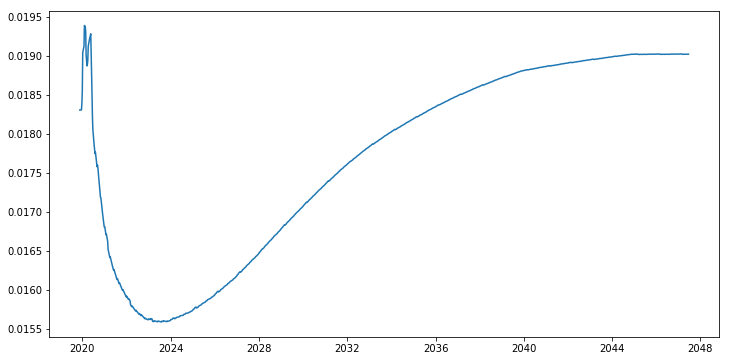

In [103]:
# Plot yield curve
fig = plot_helper(Mkt_dict["SDate"],yts)

In [135]:
# Testing for discounting curve
# BBG Curve setting and valuation results
testing = [
    [ql.Date(20,2,2020),0.995161],
    [ql.Date(18,3,2020),0.993781],
    [ql.Date(16,9,2020),0.985647],
    [ql.Date(17,3,2021),0.97818],
    [ql.Date(21,11,2022),0.954127],
    [ql.Date(20,11,2023),0.939469],
    [ql.Date(20,11,2024),0.924386],
    [ql.Date(20,11,2025),0.908912],
    [ql.Date(20,11,2026),0.893063],
    [ql.Date(20,11,2027),0.876650],
    [ql.Date(20,11,2030),0.826516],
    [ql.Date(20,11,2034),0.761420],
    [ql.Date(20,11,2039),0.686726],
    ]
Errors = 0
for test in testing:
    Dis = yts.discount(test[0])
    Errors += abs(Dis-test[1])
    print (test[0],Dis,test[1])
print("###---Error Summary---###")
print("Total Average Discounting Errors:{}".format(Errors/len(testing)))

February 20th, 2020 0.9950600960731628 0.995161
March 18th, 2020 0.993733960942611 0.993781
September 16th, 2020 0.9855772814825235 0.985647
March 17th, 2021 0.9783344204111765 0.97818
November 21st, 2022 0.9540680891641281 0.954127
November 20th, 2023 0.9394183817094383 0.939469
November 20th, 2024 0.9243244181919416 0.924386
November 20th, 2025 0.9088621844135046 0.908912
November 20th, 2026 0.8930197550870433 0.893063
November 20th, 2027 0.8767033986364512 0.87665
November 20th, 2030 0.8263941969391421 0.826516
November 20th, 2034 0.761247264785927 0.76142
November 20th, 2039 0.68637526685378 0.686726
###---Error Summary---###
Total Average Discounting Errors:0.00010268641572502419


### 1 - c Curve_Helpers:QA

1. **What is the business adjustment paramater?**
A: A way to deal with payment happended not on working date. For example "Modified following business day convention" means if a business day convention whereby payment days that fall on a holiday or a Saturday or a Sunday roll forward to the next target business day. If that day falls in the next calendar month, the payment day rolls backward to the immediately preceding target business day.
2. **Waht is SettlementDays?**
A: The settlement date is the date when a trade is final, and the buyer must make payment to the seller while the seller delivers the assets to the buyer. The settlement date for stocks and bonds is usually two business days after the execution date (T+2). For government securities and options, it's the next business day (T+1). In spot foreign exchange (FX), the date is two business days after the transaction date. Options contracts and other derivatives also have settlement dates for trades in addition to a contract's expiration dates.
3. **Waht is the output from Bootstrapping?**
A: The outpur from Boostrapping is an termstrucutre object which enable to be used for pricing and discounting factor calculation.
4. **Waht is the future convexity adjustment?** 
A: A convexity adjustment is a change required to be made to a forward interest rate or yield to get the expected future interest rate or yield. Convexity adjustment refers to the difference between the forward interest rate and the future interest rate; this difference has to be added to the former to arrive at the latter. The need for this adjustment arises because of the non-linear relationship between bond prices and yields.

### 2 - Different Curves Building

In the above section I showed how to build up the basic USD yield curve using QuantLib based on Cash Rates, Futures Rates and Swaps Rates. In this section, we will look into different curves building method. They are: FX curve and OIS curve. NOTE: Recently LIBOR will be replaced by SOFR which needs more quant-knowledge to bootstrapping.

**For FX curve:** The reason we cannot not use LIBOR curve for FX pricing is different currency has differnt credit risk associated. Those type of risks mainly includes country risk or government risk. For a given currency pair, there will be a basis spread in between such that we can use to translate one to another. In this case, the curve we will be using is called FX curve, LIBOR curve plus basis spread.

**For OIS curve:** It different from LIBOR curve because it excludes banking risks. After 2008, investor starts to pay huge attention on banking credit risks that drives the whole risk-free rate away from just LIBOR. In this case, the curve we will be using is still a derived curve from LIBOR called OIS curve, OIS quotes plus OIS spread. Details for OIS curve please refer to another paper on my site "OIS_Curve".

### 2 - a FX Curve Boostrapping
In this section I will use USD/EUR curve as an example to build out a FX curve that can be used to calcualte forward FX rates and some risk analysis for futue using. We will do the following:

1. Generate EUR LIBOR curve helpers and get a set of basis adjustments factors for different maturity.
2. Use linear interpolation to apply those basis adjustment factors on top of the EUR LIBOR curve to get a slightly different rates inputs for curve building.
3. Using Bootstrapping to get a EUR/USD basis adjusted curve for fx pricing using (also can be used for cross currency pricing.).
4. When we want to price different currency pair, for example EUR/GBP then based on the implementation of EUR/USD and GBP/USD we can do triangle calculation to get EUR/GBP.
5. In this workbook I will skip the FX pricing part, please refer to FX pricing workbook for how to use QuantLib do FX pricing.

Below are the market inputs and basis adjustment factors for EUR/USD:

NOTE: EUR LIBOR market has totaly different convention compared to USD that's why we have to rebuild the Con_dict for this currency. 

In this example, we will be using a different way to calibrate yield curve. Instead of using futures we will use FRA(Forward rate agreement) to bootstrapping EUR LIBOR curve.

In [151]:
# EUR market instruments quotes
EUR_Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.TARGET(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "FRA":{    "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "fixingDays":2,# For convexity adjustment
               "Calendar":ql.TARGET(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.EURLibor(ql.Period(6,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(6,ql.Months),
              "FloatingLegFrequency":ql.Semiannual,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Annual,
              "FixedLegTenor":ql.Period(12,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.TARGET(),
            },
}
EUR_Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): -0.0045,
             (3,ql.Months): -0.00404,
             (6,ql.Months): -0.00333,
           },
    "FRA":{    # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               (1,7,ql.Months): -0.00325,
               (2,8,ql.Months): -0.00326,
               (3,9,ql.Months): -0.00327,
               (4,10,ql.Months): -0.00330,
               (5,11,ql.Months): -0.00331,
               (6,12,ql.Months): -0.00333,
               (7,13,ql.Months): -0.00337,
               (8,14,ql.Months): -0.00340,
               (9,15,ql.Months): -0.00341,
               (10,16,ql.Months): -0.00345,
             },
    "Swap":{  (2,ql.Years): -0.00337,
              (3,ql.Years): -0.00310,
              (4,ql.Years): -0.0027,
              (5,ql.Years): -0.00220,
              (6,ql.Years): -0.00165,
              (7,ql.Years): -0.00107,
              (8,ql.Years): -0.00045,
              (9,ql.Years): 0.00017,
              (10,ql.Years): 0.00077,
              (12,ql.Years): 0.00190,
              (15,ql.Years): 0.00330,
              (20,ql.Years): 0.00455,
              (25,ql.Years): 0.00495,
              (30,ql.Years): 0.0049,
              (40,ql.Years): 0.00445,
            },
}
EURUSD_Basis = {
# For simplicity, I start with 1 year 
# if need more accuratcy we can modify it further
    "Basis":{ (1,ql.Years): -0.00169,
              (2,ql.Years): -0.0016375,
              (3,ql.Years): -0.00169375,
              (4,ql.Years): -0.00165,
              (5,ql.Years): -0.0016125,
              (6,ql.Years): -0.001675,
              (7,ql.Years): -0.0016625,
              (8,ql.Years): -0.0017375,
              (9,ql.Years): -0.0017875,
              (10,ql.Years): -0.001825,
              (12,ql.Years): -0.00190,
              (15,ql.Years): -0.001925,
              (20,ql.Years): -0.001,
              (25,ql.Years): -0.0007,
              (30,ql.Years): -0.000055,
              (40,ql.Years): -0.000055,
            }
}

In [152]:
def Basis_Adjust( Mkt_dict, Basis):
    # Apply basis adjustment on top of LIBOR curve
    year_li = [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40]
    Y1_bs = Basis["Basis"][(1,ql.Years)]
    for key,val in Mkt_dict["Cash"].items():
        Mkt_dict["Cash"][key] += Y1_bs
    for key,val in Mkt_dict["FRA"].items():
        Mkt_dict["FRA"][key] += Y1_bs
    for yy in year_li:
        Mkt_dict["Swap"][(yy,ql.Years)] += Basis["Basis"][(yy,ql.Years)]
    return Mkt_dict

In [153]:
# Test to validate basis adjustment
EUR_Mkt_dict = Basis_Adjust( EUR_Mkt_dict, EURUSD_Basis)
print(EUR_Mkt_dict)

{'SDate': Date(18,11,2019), 'Cash': {(1, 2): -0.006189999999999999, (3, 2): -0.005730000000000001, (6, 2): -0.00502}, 'FRA': {(1, 7, 2): -0.00494, (2, 8, 2): -0.0049499999999999995, (3, 9, 2): -0.00496, (4, 10, 2): -0.00499, (5, 11, 2): -0.005, (6, 12, 2): -0.00502, (7, 13, 2): -0.00506, (8, 14, 2): -0.00509, (9, 15, 2): -0.0051, (10, 16, 2): -0.0051400000000000005}, 'Swap': {(2, 3): -0.0050075, (3, 3): -0.004793749999999999, (4, 3): -0.00435, (5, 3): -0.0038125, (6, 3): -0.003325, (7, 3): -0.0027324999999999997, (8, 3): -0.0021874999999999998, (9, 3): -0.0016175, (10, 3): -0.001055, (12, 3): 0.0, (15, 3): 0.001375, (20, 3): 0.00355, (25, 3): 0.00425, (30, 3): 0.0048449999999999995, (40, 3): 0.004395}}


In [154]:
def Bootstrapping_FRA( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    FRAs     = Market["FRA"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    FRA_con       = Convention["FRA"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in FRAs.keys():
        FRAs[d] = ql.SimpleQuote(FRAs[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    FRAHelpers = [ ql.FraRateHelper( ql.QuoteHandle(FRAs[d]),
                                     d[0],d[1],
                                     FRA_con["fixingDays"],
                                     FRA_con["Calendar"], FRA_con["BsDay"],
                                     FRA_con["EOM"], FRA_con["DayCount"] )
                       for d in FRAs.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + FRAHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    return yts

In [155]:
# Get TermStructure object
FX_yts = Bootstrapping_FRA(EUR_Mkt_dict, EUR_Con_dict)

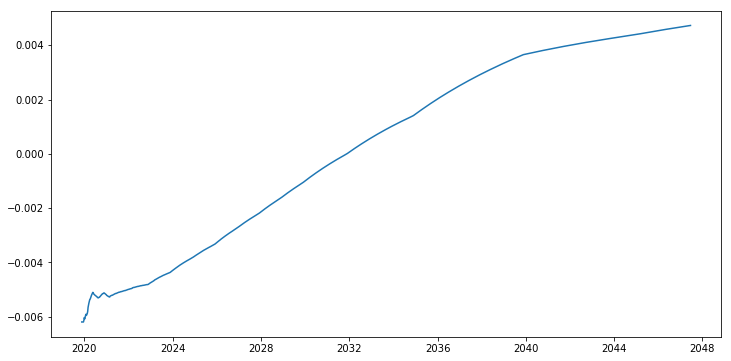

In [156]:
# Plot Yield curve 
fig = plot_helper(EUR_Mkt_dict["SDate"],FX_yts)

In [157]:
# Testing on FX curve with BBG value
testing = [
    [ql.Date(21,5,2020),1.004212],
    [ql.Date(20,11,2020),1.00807],
    [ql.Date(20,11,2021),1.015625],
    [ql.Date(21,11,2022),1.022587],
    [ql.Date(20,11,2023),1.028551],
    [ql.Date(20,11,2024),1.033427],
    [ql.Date(20,11,2025),1.037011],
    [ql.Date(20,11,2026),1.039984],
    [ql.Date(20,11,2027),1.040538],
    [ql.Date(20,11,2034),1.012700],
    [ql.Date(20,11,2039),0.977554],
    ]
Errors = 0
for test in testing:
    Dis = FX_yts.discount(test[0])
    Errors += abs(Dis-test[1])
    print (test[0],Dis,test[1])
print("###---Error Summary---###")
print("Total Average Discounting Errors:{}".format(Errors/len(testing)))

May 21st, 2020 1.0025945298187944 1.004212
November 20th, 2020 1.0051578436895778 1.00807
November 20th, 2021 1.010128719569832 1.015625
November 21st, 2022 1.0145722986536438 1.022587
November 20th, 2023 1.0176409895877874 1.028551
November 20th, 2024 1.0193517410225914 1.033427
November 20th, 2025 1.0202740658518135 1.037011
November 20th, 2026 1.019453104017151 1.039984
November 20th, 2027 1.017827769647103 1.040538
November 20th, 2034 0.9792529236754982 1.0127
November 20th, 2039 0.9295492302645842 0.977554
###---Error Summary---###
Total Average Discounting Errors:0.016768707654693012


### 2 - b OIS Curve Boostrapping
In this section I will walk you through OIS bootstrapping. I will not talk about much about why we have to do OIS curve as the true risk free curve. Details please refer to my paper "OIS discounting". The way we will be using to build this type of curve is inline with Bloomberg curve building function as following:(Take USD as example)

1. Using OIS quote from Fed Rate upto 30 years OIS rate and take OIS spread quote from year1 to year30.
2. For OIS pricing purpose, we will use dual curve to raw OIS curve for forward cash flow projection and the adjusted OIS curve for discounting. Previously we want to derive FX curve from LIBOR curve but now we want to derive LIBOR curve(adjusted OIS curve) from raw OIS curve.

** NOTE **: This implementation looks similar to FX curve building by applying an basis adjusted rate on top of a raw curve. But the direction is opposite to what we have previously. 

- Market instruments for OIS curve building is different from LIBOR curve.
- Basis adjustment starting from year1 but we also need to apply adjustment within year1.


In [177]:
OIS_Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "OIS":{ "Index":ql.OvernightIndex("FED", 2, ql.USDCurrency(), ql.UnitedStates(), ql.Actual360()), # Floating Leg index rate
            },
}
OIS_Mkt_dict = {
    "SDate": ql.Date(19,11,2019), # Curve starting date
    "OIS":{   (1,ql.Weeks): 0.0156,
              (2,ql.Weeks): 0.01565,
              (3,ql.Weeks): 0.01567,
              (2,ql.Months): 0.01555,
              (3,ql.Months): 0.01544,
              (6,ql.Months): 0.01506,
              (12,ql.Months): 0.01433,
              (18,ql.Months): 0.0137,
              (2,ql.Years): 0.0134,
              (3,ql.Years): 0.01315,
              (5,ql.Years): 0.0133,
              (7,ql.Years): 0.01372,
              (10,ql.Years): 0.01456,
              (12,ql.Years): 0.01503,
              (15,ql.Years): 0.01558,
              (20,ql.Years): 0.01613,
            },
}
def Bootstrapping_OIS( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    OISs     = Market["OIS"]
    OISs_con = Convention["OIS"]
    for n,unit in OISs.keys():
        OISs[(n,unit)] = ql.SimpleQuote(OISs[(n,unit)])
    # Build up helpers for curve building
    OISHelpers = [ ql.OISRateHelper( 2,
                                     ql.Period(n,unit),
                                     ql.QuoteHandle(OISs[(n,unit)]),
                                     Convention["OIS"]["Index"]
                                   )
                    for n, unit in OISs.keys() ]
    # term-structure construction
    helpers = OISHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    return yts

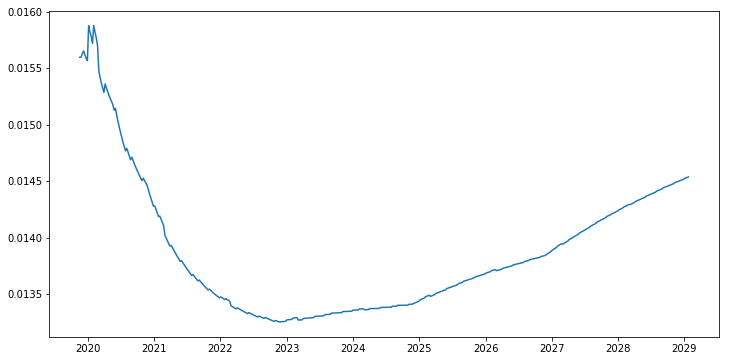

In [178]:
# Get TermStructure object
OIS_yts = Bootstrapping_OIS(OIS_Mkt_dict, OIS_Con_dict)
# Plot Yield curve 
fig = plot_helper(OIS_Mkt_dict["SDate"],OIS_yts,10)

In [180]:
# Testing on FX curve with BBG value
testing = [
    [ql.Date(23,1,2020),0.997371],
    [ql.Date(25,5,2021),0.97951],
    [ql.Date(24,11,2021),0.973293],
    [ql.Date(23,11,2022),0.961003],
    [ql.Date(24,11,2023),0.948311],
    [ql.Date(25,11,2024),0.935156],
    ]
Errors = 0
for test in testing:
    Dis = OIS_yts.discount(test[0])
    Errors += abs(Dis-test[1])
    print (test[0],Dis,test[1])
print("###---Error Summary---###")
print("Total Average Discounting Errors:{}".format(Errors/len(testing)))

January 23rd, 2020 0.9972015773931316 0.997371
May 25th, 2021 0.9793009118857002 0.97951
November 24th, 2021 0.9731604417590645 0.973293
November 23rd, 2022 0.9608775517754601 0.961003
November 24th, 2023 0.947837062516126 0.948311
November 25th, 2024 0.9349254492044597 0.935156
###---Error Summary---###
Total Average Discounting Errors:0.0002235009110096442


<font color='blue'>
**To summarize**:
1. We have using QAuantLib to bootstrap yield curve with three major types they are: LIBOR curve, FX curve and OIS curve. They will be used further to price swaps and fx and even other derivatives based on interests rate curve.
2. Besides of this, there are plenty of different curves in the market. For example, USD we can use 3ML market instruments but we also can use 6ML market instruments. If we switch to a different curve setting the yield curve will be different. However, one would ask how about the pricing? A quick answer is different, because "Libor is not equal to Libor" this is a well know effects when we swithcing from 6ML to 3ML the different is called maturity basis spread.
3. To further use and implement this program, we need to wrap it with object-orianted programming structure. 

**Summary QA**:
- **How to recognize what type of curve to build and how to find corresponding market instruments?**
A: Please refer to the acutal trade details for curve building, say if the trade specified 3ML then we should build 3ML Libor as well. After confirmed with the curve to use, please go to BBG ICVS to find out the exact curve. At that page, all market instruments will be available to you. Look carefully on the instrument conventions.
- **How to check if current curve is good enough to use for Risk purpose?**
A: The same function in ICVS will also give you a discoutning table. Please wirte a simple program to check if all dates in that table is close enough to the curve you are building. Generally difference within 1bps is acceptable.